In [2]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2
import os
from random import shuffle
from tqdm import tqdm
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [3]:
# setting path of directory
M_DIR =  "drive/MyDrive/Monkeypox/Fold1/Train/Monkeypox/"
O_DIR = "drive/MyDrive/Monkeypox/Fold1/Train/Others/"


# storing all the files from directories M_DIR and O_DIR to Mimages and Oimages for accessing images directly

Mimages = os.listdir(M_DIR)
Oimages = os.listdir(O_DIR)

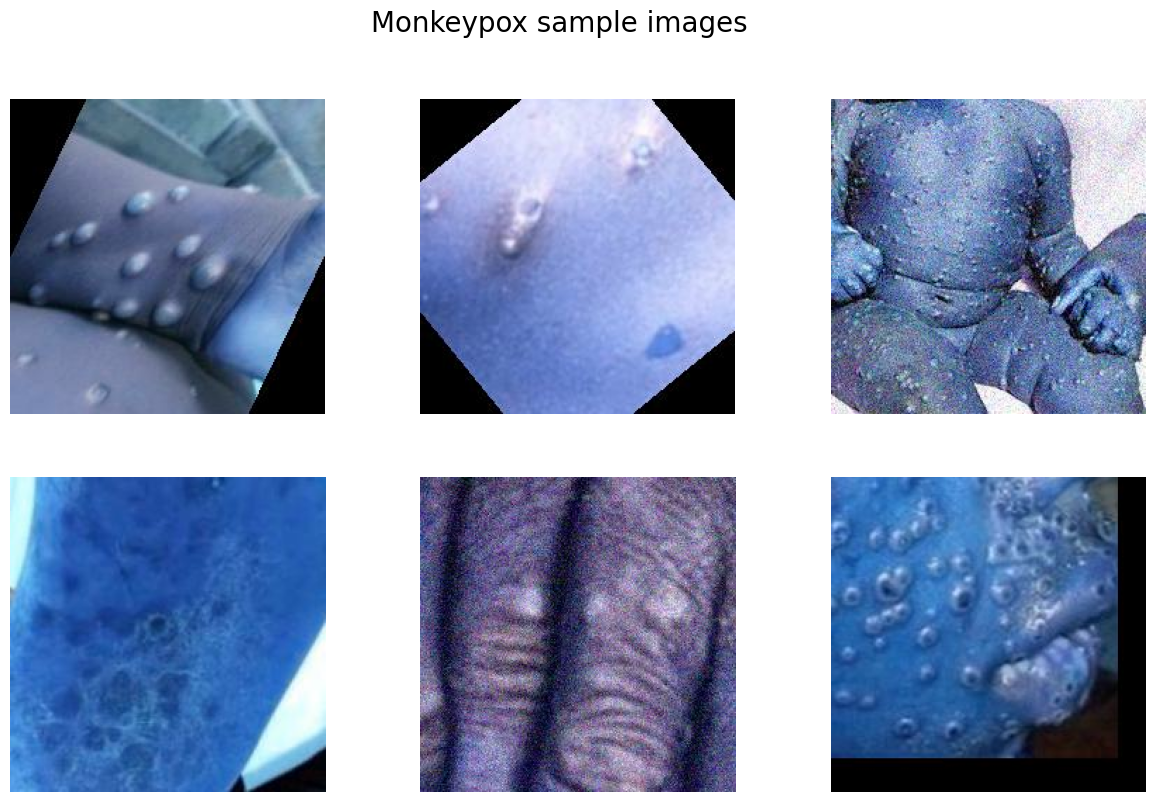

In [4]:
sample_monkeypox = random.sample(Mimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(M_DIR +sample_monkeypox[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Monkeypox sample images',fontsize=20)
plt.show()

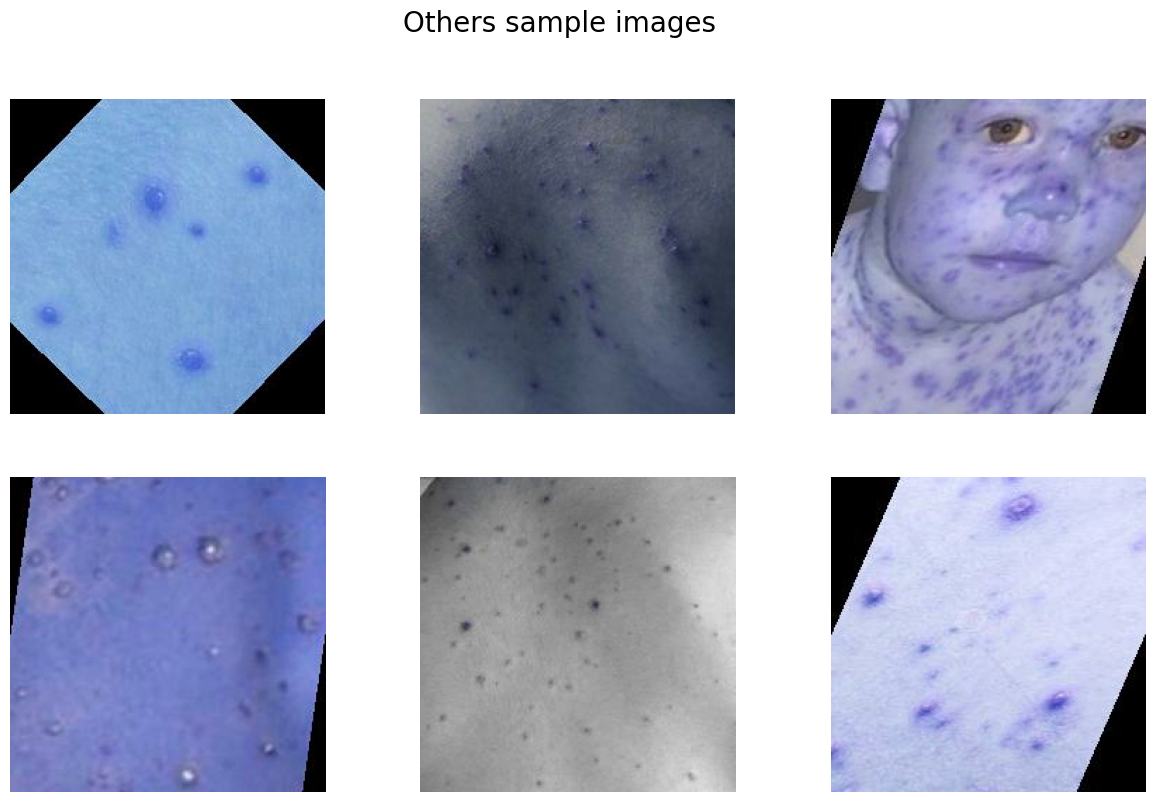

In [5]:
sample_others = random.sample(Oimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(O_DIR +sample_others[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Others sample images',fontsize=20)
plt.show()

In [6]:
data=[]
labels=[]
for m in Mimages:
    try:
        image=cv2.imread(M_DIR+m)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

for o in Oimages:
    try:
        image=cv2.imread(O_DIR+o)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

In [7]:
#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

# saving features and labels for later re-use
# np.save("drive/MyDrive/Monkeypox/feats_train",feats)
# np.save("drive/MyDrive/Monkeypox/labels_train",labels)

In [8]:
feats=np.load("drive/MyDrive/Monkeypox/feats_train.npy")
labels=np.load("drive/MyDrive/Monkeypox/labels_train.npy")

s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]

num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)

2142


In [9]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]

(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

In [10]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)


#Doing One hot encoding as classifier has multiple classes
y_train=to_categorical(y_train,num_classes)
y_test=to_categorical(y_test,num_classes)




In [11]:
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (1714, 224, 224, 3)
x_test shape: (428, 224, 224, 3)
y_train shape: (1714, 2)
y_test shape: (428, 2)


In [12]:
# Hyper parameters
epochs = 8
batch_size = 32

conv_base = MobileNetV2(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

<ipython-input-12-bd9fa879fceb>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [14]:
# Define the optimizer
#optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, None, None, 96) │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,430,338 (9.27 MB)

 Trainable params: 2,396,226 (9.14 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [15]:
checkpoint = ModelCheckpoint('.mdl_wts.hdf5.keras', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)



callbacks = [checkpoint,reduce_lr]

In [16]:
history = model.fit(x_train,y_train,batch_size=batch_size,callbacks=callbacks, validation_data=(x_test,y_test),epochs=epochs,verbose=1)

Epoch 1/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7005 - loss: 0.5306
Epoch 1: val_accuracy improved from -inf to 0.53505, saving model to .mdl_wts.hdf5.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 395s 7s/step - accuracy: 0.7023 - loss: 0.5286 - val_accuracy: 0.5350 - val_loss: 11.5327 - learning_rate: 0.0010
Epoch 2/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8857 - loss: 0.2689
Epoch 2: val_accuracy improved from 0.53505 to 0.74533, saving model to .mdl_wts.hdf5.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 371s 6s/step - accuracy: 0.8859 - loss: 0.2687 - val_accuracy: 0.7453 - val_loss: 1.4016 - learning_rate: 0.0010
Epoch 3/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9068 - loss: 0.2289
Epoch 3: val_accuracy did not improve from 0.74533
54/54 ━━━━━━━━━━━━━━━━━━━━ 392s 7s/step - accuracy: 0.9069 - loss: 0.2285 - val_accuracy: 0.6168 - val_loss: 5.7141 - learning_rate: 0.0010
Epoch 4/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9375 - loss: 0.1602
Epoch 4: val_accura

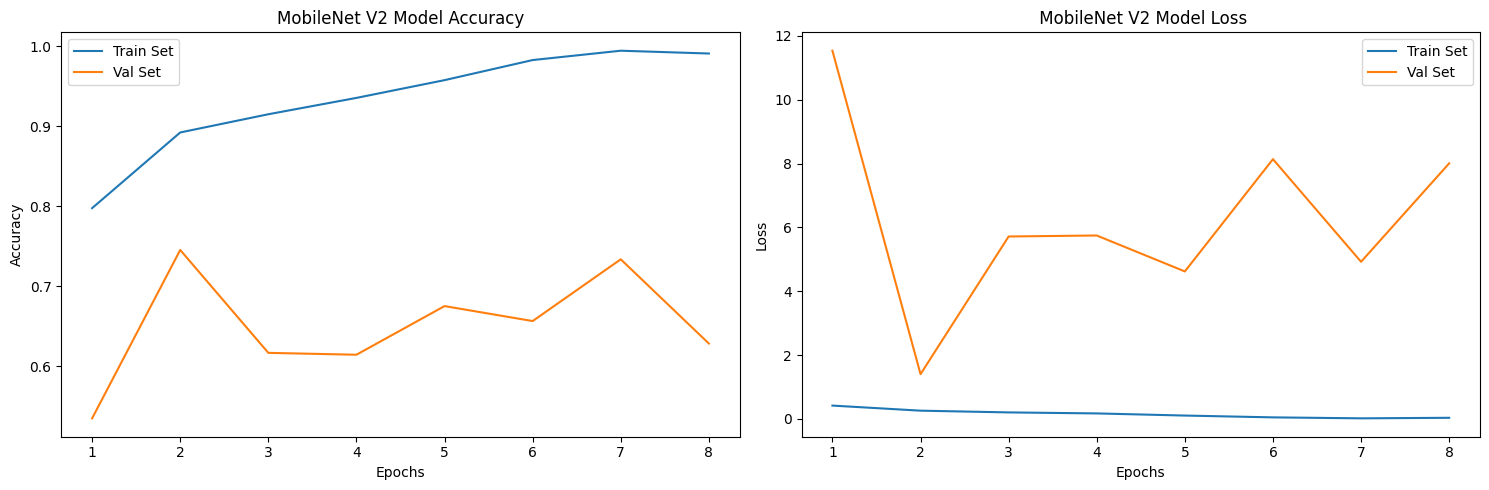

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' MobileNet V2 Model Loss')

plt.tight_layout()
plt.show()

increase the epoch size for more accuracy

In [18]:
# saving the weight of model
from numpy import loadtxt
from keras.models import load_model
model = load_model('.mdl_wts.hdf5.keras')

#checking the score of the model
score=model.evaluate(x_test,y_test)
print(score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 958ms/step - accuracy: 0.7568 - loss: 1.3406
[1.4015626907348633, 0.7453271150588989]


In [19]:
# setting the path of validation directory
M_VDIR =  "drive/MyDrive/Monkeypox/Fold1/Val/Monkeypox/"
O_VDIR = "drive/MyDrive/Monkeypox/Fold1/Val/Others/"

# storing all the files from directories M_VDIR and O_VDIR to MVimages and OVimages for accessing images directly
MVimages = os.listdir(M_VDIR)
OVimages = os.listdir(O_VDIR)

data=[]
labels=[]

for m in MVimages:
    try:
        image=cv2.imread(M_VDIR+m)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

for o in OVimages:
    try:
        image=cv2.imread(O_VDIR+o)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

# saving features and labels for later re-use
np.save("drive/My Drive/Monkeypox/feats_val",feats)
np.save("drive/My Drive/Monkeypox/labels_val",labels)

# loading validation data
x_val=np.load("/content/drive/MyDrive/Monkeypox/feats_val.npy")
y_val=np.load("/content/drive/MyDrive/Monkeypox/labels_val.npy")

s=np.arange(x_val.shape[0])
np.random.shuffle(s)
x_val=x_val[s]
y_val=y_val[s]

# image normalization
x_val = x_val.astype('float32')/255
#one hot encoding
y_val=to_categorical(y_val,num_classes)

# checking the accuracy on valdation data
accuracy = model.evaluate(x_val, y_val, verbose=1)
print('\n', 'Validation_Accuracy:-', accuracy[1])

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7020 - loss: 2.1571

 Validation_Accuracy:- 0.6952381134033203


14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


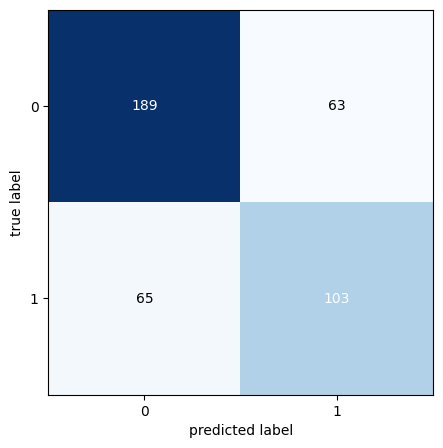

In [20]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_val)
pred = np.argmax(pred,axis = 1)
y_true = np.argmax(y_val,axis = 1)

#creating confusion matrix
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
# plotting confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [21]:
print('{}'.format(
                           classification_report(y_true , pred)))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75       252
           1       0.62      0.61      0.62       168

    accuracy                           0.70       420
   macro avg       0.68      0.68      0.68       420
weighted avg       0.69      0.70      0.69       420



14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


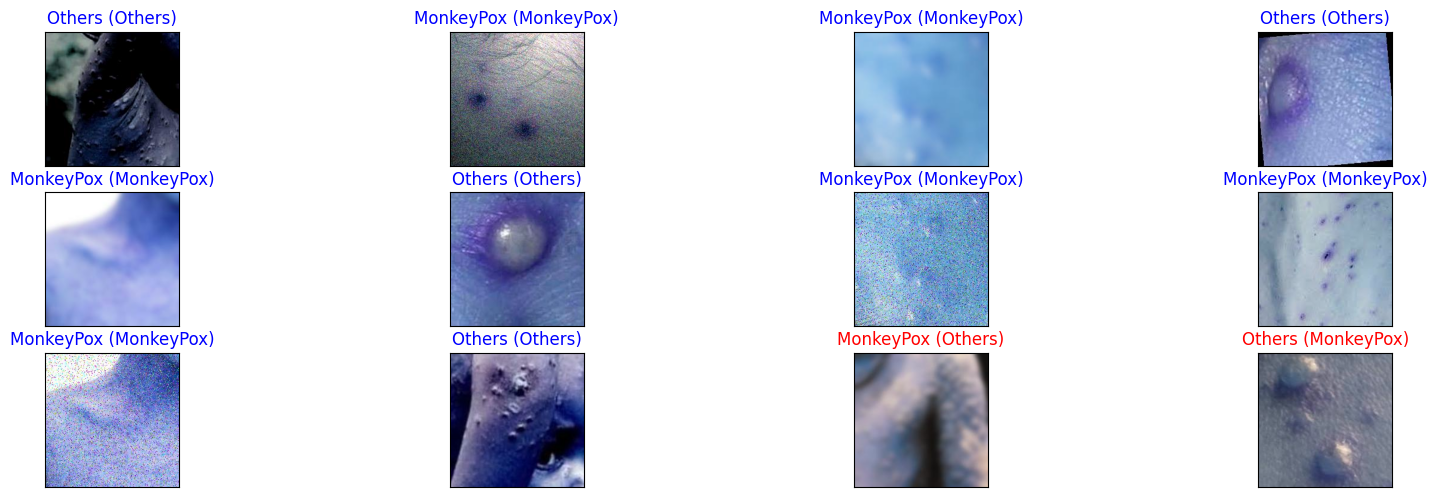

In [24]:
y_hat = model.predict(x_val)

# define text labels
m_labels = ['MonkeyPox','Others']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_val.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_val[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_val[idx])
    ax.set_title("{} ({})".format(m_labels[pred_idx], m_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))

In [36]:

import cv2
from PIL import Image
import numpy as np
import tensorflow as tf

# Assuming 'model' is your trained Keras model

def predict_monkeypox(image_path):
    """
    Predicts whether an image contains monkeypox or not.

    Args:
        image_path (str): Path to the input image.

    Returns:
        str: Prediction label ("MonkeyPox" or "Others").
    """

    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to RGB format
    image_from_array = Image.fromarray(image, 'RGB')

    # Resize the image to the input size expected by the model
    size_image = image_from_array.resize((224, 224))  # Assuming your model expects 224x224 images

    # Convert the image to a NumPy array and normalize
    image_array = np.array(size_image)
    image_array = image_array.astype('float32') / 255  # Normalize the image

    # Reshape the array to match the model's input shape
    # (add a batch dimension)
    image_array = image_array.reshape(1, 224, 224, 3)  # Assuming your model expects 3 color channels

    # Make the prediction
    prediction = model.predict(image_array)

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)

    # Define text labels
    m_labels = ['MonkeyPox', 'Others']

    # Return the predicted label
    return m_labels[predicted_class_index]


# Example usage:
image_path = "drive/MyDrive/Monkeypox/ss.png"  # Replace with the path to your image
prediction = predict_monkeypox(image_path)
print("Prediction:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction: MonkeyPox


In [37]:


import cv2
from PIL import Image
import numpy as np
import tensorflow as tf

# Assuming 'model' is your trained Keras model

def predict_monkeypox(image_path):
    """
    Predicts whether an image contains monkeypox or not.

    Args:
        image_path (str): Path to the input image.

    Returns:
        str: Prediction label ("MonkeyPox" or "Others").
    """

    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to RGB format
    image_from_array = Image.fromarray(image, 'RGB')

    # Resize the image to the input size expected by the model
    size_image = image_from_array.resize((224, 224))  # Assuming your model expects 224x224 images

    # Convert the image to a NumPy array and normalize
    image_array = np.array(size_image)
    image_array = image_array.astype('float32') / 255  # Normalize the image

    # Reshape the array to match the model's input shape
    # (add a batch dimension)
    image_array = image_array.reshape(1, 224, 224, 3)  # Assuming your model expects 3 color channels

    # Make the prediction
    prediction = model.predict(image_array)

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)

    # Define text labels
    m_labels = ['MonkeyPox', 'Others']

    # Return the predicted label
    return m_labels[predicted_class_index]


# Example usage:
image_path = "drive/MyDrive/Monkeypox/ssno.png"  # Replace with the path to your image
prediction = predict_monkeypox(image_path)
print("Prediction:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Prediction: Others


In [38]:
# model.save('my_monkeypox_model.h5')